In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# python imports
import os
from pprint import pprint
from random import shuffle
import imageio
import progressbar as pb

print("Numpy {}".format(np.__version__))
print("Tensorflow {}".format(tf.__version__))

print("\nAdditional Modules:")
print("progressbar2 {}".format(pb.__version__))

np.set_printoptions(precision=5, suppress=True)

# build keras model
gpu_options = tf.GPUOptions(allow_growth=True) # allow growth to not reserve complete memory of gpu
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
keras.backend.set_session(sess)

Numpy 1.16.2
Tensorflow 1.13.1

Additional Modules:
progressbar2 3.39.3


In [2]:
#config_modelname="sigmoid-190509"
#config_modelname="relu-190509"
config_modelname="tanh-190509"

#activation_function = keras.activations.sigmoid
#activation_function = keras.activations.relu
activation_function = keras.activations.tanh

config = dict(
    logdir="./output/ml_log/",
    inputfolder="./input/classes_r3",
    checkpoint="./output/ml_log/tensorflow_checkpoint.h5",
    model="./output/{}.h5".format(config_modelname),
    model_map="./output/{}.map".format(config_modelname),
    split_train=0.85,
)
pprint(config)

os.makedirs(config["logdir"], exist_ok=True)

{'checkpoint': './output/ml_log/tensorflow_checkpoint.h5',
 'inputfolder': './input/classes_r3',
 'logdir': './output/ml_log/',
 'model': './output/tanh-190509.h5',
 'model_map': './output/tanh-190509.map',
 'split_train': 0.85}


In [3]:
def parse_file(path, label):
    #label = tf.string_split([path], delimiter=os.sep).values[-2]
    image_string = tf.read_file(path)
    image_decoded = tf.image.decode_png(image_string, channels=1)
    image_decoded = tf.image.per_image_standardization(image_decoded)
    image_resized = tf.image.resize_images(image_decoded, [100, 100])
    return image_resized, label

# collect subfolders of inputfolder
# util.recursive_collect(config["inputfolder"])
directories = [os.path.join(config["inputfolder"], child) for child in os.listdir(config["inputfolder"])]
paths = []
labels = []
label_name = dict()
for directory, label in zip(directories, range(len(directories))):
    children = os.listdir(directory)
    paths.extend([os.path.join(directory, child) for child in children])
    labels.extend([int(label)] * len(children))
    label_name[label] = (len(children), directory.split(os.sep)[-1])

split_train = int(config["split_train"] * len(paths))
    
# create lookup table to get integer indices
# https://www.tensorflow.org/api_docs/python/tf/contrib/lookup/index_table_from_tensor
classes = list(map(lambda x: x.split(os.sep)[-1], directories))
print("total images: {}".format(len(paths)))
pprint(label_name)

#for p,l in zip(paths, labels):
#    print("{} -> {}: {}".format(p, l, label_name[l]))

# create final dataset
dataset = tf.data.Dataset.from_tensor_slices((paths,labels))
dataset = dataset.map(parse_file, num_parallel_calls=os.cpu_count())
dataset = dataset.cache(filename=r"c:\temp\tf_cache")
dataset = dataset.shuffle(10000, reshuffle_each_iteration=True)

# split off a dataset for training
train_dataset = dataset.take(split_train)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(512)

# split validation set off and use rest for test
test_dataset = dataset.skip(split_train)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(32)

#iterator = dataset.make_one_shot_iterator()
#with tf.Session() as sess:
#    print(sess.run(iterator.get_next()))

total images: 2094
{0: (129, '1_home'),
 1: (128, '2.1_moving'),
 2: (117, '2.2_moving_wafer'),
 3: (188, '3.1_cassette_location_empty'),
 4: (198, '3.2_cassette_location_unknown'),
 5: (163, '3.3_cassette_location_wafer'),
 6: (399, '4.1_processchamber_empty'),
 7: (206, '4.2_processchamber_unknown'),
 8: (141, '4.3_processchamber_wafer'),
 9: (106, '5.1_cooling_station_wafer'),
 10: (149, '5.2_cooling_station_unknown'),
 11: (170, '5.3_cooling_station_empty')}
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


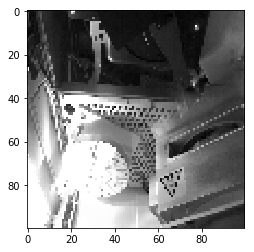

6: (399, '4.1_processchamber_empty')


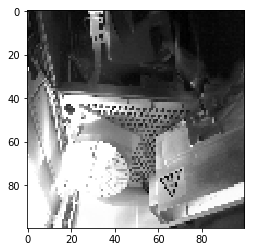

1: (128, '2.1_moving')


In [4]:
# problem: labels are off and model thinks it's correct
# -> seems like error is even earlier
import traceback
def check_dataset(input_dataset, limit=None):
    #pprint(input_dataset)
    iterator = input_dataset.make_one_shot_iterator()
    try:
        count = 0
        count_total = 0
        while count < 1:
            count += 1
            el = iterator.get_next()
            with tf.Session() as sess:
                el = sess.run(el)
            labels = el[1]
            images = el[0]
            for img, lab in zip(images, labels):
                if type(img) is str or type(img) is bytes:
                    print(str(img))
                else:
                    plt.imshow(np.squeeze(img), "gray"), plt.show();
                print("{}: {}".format(lab, label_name[lab]))
                count_total += 1
                if limit is not None and count_total >= limit:
                    break
    except tf.errors.OutOfRangeError:
        pass
    except TypeError:
        traceback.print_exc()
    
#check_dataset(dataset, limit=1)
check_dataset(train_dataset, limit=1)
check_dataset(test_dataset, limit=1)

In [5]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(100, 100, 1)),
    keras.layers.Dense(256, activation=activation_function),
    keras.layers.Dense(128, activation=activation_function),
    keras.layers.Dropout(rate=0.8),
    keras.layers.Dense(64, activation=activation_function),
    keras.layers.Dense(16, activation=activation_function),
    keras.layers.Dense(len(classes), activation=tf.nn.softmax)
])

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    config["checkpoint"], 
    save_best_only=None, 
    verbose=0, 
    mode='max'
)
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir='./output/ml_log', 
    histogram_freq=1, 
    batch_size=32, 
    write_graph=True, 
    write_grads=False, 
    write_images=True, 
    embeddings_freq=0, 
    embeddings_layer_names=None, 
    embeddings_metadata=None, 
    embeddings_data=None,
)

model.fit(
    train_dataset, 
    epochs=10, 
    steps_per_epoch=100, 
    #callbacks = [checkpoint_callback, tensorboard_callback], validation_data=test_dataset, validation_steps=32, 
    callbacks = [checkpoint_callback]
)
model.summary()

Epoch 1/10
100/100 [==============================] - 7s 74ms/step - loss: 1.7354 - acc: 0.4414
Epoch 2/10
100/100 [==============================] - 6s 55ms/step - loss: 0.7368 - acc: 0.8053
Epoch 3/10
100/100 [==============================] - 6s 56ms/step - loss: 0.4476 - acc: 0.8933
Epoch 4/10
100/100 [==============================] - 6s 56ms/step - loss: 0.2721 - acc: 0.9530
Epoch 5/10
100/100 [==============================] - 5s 54ms/step - loss: 0.1959 - acc: 0.9650
Epoch 6/10
100/100 [==============================] - 6s 56ms/step - loss: 0.1627 - acc: 0.9701
Epoch 7/10
100/100 [==============================] - 6s 56ms/step - loss: 0.1715 - acc: 0.9611
Epoch 8/10
100/100 [==============================] - 6s 56ms/step - loss: 0.2087 - acc: 0.9488
Epoch 9/10
100/100 [==============================] - 6s 55ms/step - loss: 0.2299 - acc: 0.9404
Epoch 10/10
100/100 [==============================] - 5s 54ms/step - loss: 0.1721 - acc: 0.9622
_______________________________________

In [7]:
print("saving model...")
model.save(config["model"])

# store label mapping into file
import yaml
with open(config["model_map"], 'w') as f:
    yaml.dump(label_name, f, default_flow_style=False)
print("done.")

saving model...
done.


In [10]:
print("loading model")
model = keras.models.load_model(config["model"])

# load label mapping from file
import yaml
with open(config["model_map"], 'r') as f:
    label_name = yaml.full_load(f)

model.summary()
print("done.")

loading model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               2560256   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_4 (Dense)              (None, 12)                204    

In [11]:
print(train_dataset)
print(test_dataset)

test_loss, test_acc = model.evaluate(test_dataset, steps=1000)
pprint(test_loss)
pprint(test_acc)

<DatasetV1Adapter shapes: ((?, 100, 100, 1), (?,)), types: (tf.float32, tf.int32)>
<DatasetV1Adapter shapes: ((?, 100, 100, 1), (?,)), types: (tf.float32, tf.int32)>
1000/1000 [==============================] - 16s 16ms/step - loss: 0.0975 - acc: 0.9802
0.09750039828568698
0.98021877


In [12]:
np.set_printoptions(precision=5,threshold=5)

def result_to_color(prediction, index, predicted_label, label):
    if label == index:
        color = (32,(0,255,0))
    else:
        if prediction[index] > 1e-4:
            if index == predicted_label:
                color = (31,(0,0,255))
            else:
                color = (33,(0,255,255))
        else:
            color = (30,(128,0,0))
    return color

def pprint_result(prediction, label, img=None):
    predicted_label = np.argmax(prediction)
    if img is not None:
        plt.imshow(np.squeeze(img), "gray"), plt.show();
    
    confusion_labels.append(label)
    confusion_predictions.append(predicted_label)
    
    put = prediction[0]
    color = result_to_color(prediction, 0, predicted_label, label)
    str = "[\x1b[{}m{:.4f}".format(color[0], put)
    for j in range(1, len(prediction)):
        put = prediction[j]
        color = result_to_color(prediction, j, predicted_label, label)
        str += " \x1b[{}m{:.4f}".format(color[0], put)
    str += "\x1b[0m] {} ({}<>{})".format(label_name[label][1], label, predicted_label)
    print(str)
    return str

confusion_labels = list()
confusion_predictions = list()

pprint(label_name)
iterator = test_dataset.make_one_shot_iterator()
try:
    count = 0
    while count < 50:
        count += 1
        el = iterator.get_next()
        with tf.Session() as sess:
            el = sess.run(el)
        labels = el[1]
        images = el[0]
        for img, lab in zip(images, labels):
            img = np.expand_dims(img, axis=0)
            pred = model.predict(img, steps=1) # is single image, so no more steps
            pprint_result(pred[0], lab)#, img)
except tf.errors.OutOfRangeError:
    pass
np.set_printoptions(precision=5, threshold=None)

{0: (129, '1_home'),
 1: (128, '2.1_moving'),
 2: (117, '2.2_moving_wafer'),
 3: (188, '3.1_cassette_location_empty'),
 4: (198, '3.2_cassette_location_unknown'),
 5: (163, '3.3_cassette_location_wafer'),
 6: (399, '4.1_processchamber_empty'),
 7: (206, '4.2_processchamber_unknown'),
 8: (141, '4.3_processchamber_wafer'),
 9: (106, '5.1_cooling_station_wafer'),
 10: (149, '5.2_cooling_station_unknown'),
 11: (170, '5.3_cooling_station_empty')}
[0.0028 0.0282 0.0002 0.0000 0.0001 0.0003 0.9603 0.0032 0.0042 0.0000 0.0000 0.0007] 4.1_processchamber_empty (6<>6)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0055 0.0069 0.0001 0.0062 0.9770 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0002 0.0003 0.9512 0.0011 0.0004 0.0375 0.0001 0.0006 0.0019 0.005

[0.0002 0.0159 0.0002 0.0002 0.0002 0.0030 0.0073 0.9716 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.9712 0.0105 0.0001 0.0003 0.0109 0.0016 0.0045 0.0002 0.0001 0.0003 0.0000 0.0003] 1_home (0<>0)
[0.0008 0.0299 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0011 0.0003 0.0025 0.9642] 5.3_cooling_station_empty (11<>11)
[0.0012 0.0081 0.0001 0.0000 0.0000 0.0003 0.9859 0.0024 0.0018 0.0000 0.0000 0.0002] 4.1_processchamber_empty (6<>6)
[0.0002 0.0003 0.9512 0.0011 0.0004 0.0375 0.0001 0.0006 0.0019 0.0056 0.0010 0.0001] 2.2_moving_wafer (2<>2)
[0.0040 0.0035 0.0002 0.0121 0.9761 0.0019 0.0001 0.0007 0.0002 0.0010 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.2_cassette_location_unknown (4<>3)
[0.0002 0.0159 0.0002 0.0002 0.0002 0.0030 0.0073 0.9716 0.0007 0.0

[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0055 0.0069 0.0001 0.0062 0.9769 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0002 0.0158 0.0002 0.0002 0.0002 0.0030 0.0073 0.9717 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0010 0.0003 0.9482 0.0008 0.0002 0.0260 0.0016 0.0001 0.0047 0.0169 0.0001 0.0001] 2.2_moving_wafer (2<>2)
[0.0002 0.0001 0.9835 0.0006 0.0001 0.0067 0.0003 0.0001 0.0019 0.0064 0.0001 0.0001] 2.2_moving_wafer (2<>2)
[0.0000 0.0002 0.0010 0.0008 0.0004 0.0001 0.0000 0.0011 0.0009 0.0025 0.9852 0.0078] 5.2_cooling_station_unknown (10<>10)
[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0042 0.9295 0.0002 0.0000 0.0004 0.0000 0.0087 0.0079 0.0025 0.0000 0.0004 0.0462] 2.1_moving (1<>1)
[0.0001 0.0034 0.0043 0.0014 0.0001 0.0001 0.0028 0.0018 0.9850 0.00

[0.0000 0.0002 0.0010 0.0008 0.0004 0.0001 0.0000 0.0011 0.0010 0.0025 0.9852 0.0078] 5.2_cooling_station_unknown (10<>10)
[0.0002 0.0158 0.0002 0.0002 0.0002 0.0030 0.0073 0.9717 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0002 0.0174 0.0002 0.0002 0.0003 0.0028 0.0067 0.9707 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0001 0.0089 0.0085 0.0088 0.0011 0.0027 0.0097 0.0782 0.8710 0.0002 0.0090 0.0017] 4.3_processchamber_wafer (8<>8)
[0.0055 0.0069 0.0001 0.0062 0.9769 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0012 0.0072 0.0000 0.0000 0.0000 0.0003 0.9872 0.0023 0.0016 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0053 0.0064 0.0001 0.0066 0.9774 0.0022 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0002 0.0158 0.0002 0.0002 0.0002 0

[0.0001 0.0036 0.0038 0.0018 0.0001 0.0002 0.0038 0.0024 0.9831 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0001 0.0034 0.0043 0.0014 0.0001 0.0001 0.0028 0.0018 0.9850 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0039 0.0431 0.0002 0.0000 0.0001 0.0004 0.9424 0.0037 0.0049 0.0000 0.0000 0.0011] 2.1_moving (1<>6)
[0.0055 0.0069 0.0001 0.0062 0.9770 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0001 0.0002 0.9885 0.0008 0.0001 0.0040 0.0001 0.0002 0.0017 0.0041 0.0003 0.0001] 2.2_moving_wafer (2<>2)
[0.0021 0.0182 0.0001 0.0000 0.0001 0.0003 0.9727 0.0028 0.0032 0.0000 0.0000 0.0004] 4.1_processchamber_empty (6<>6)
[0.0012 0.0081 0.0001 0.0000 0.0000 0.0003 0.9860 0.0024 0.0018 0.0000 0.

[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0001 0.0034 0.0043 0.0014 0.0001 0.0001 0.0028 0.0018 0.9850 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0000 0.0002 0.0010 0.0008 0.0004 0.0001 0.0000 0.0011 0.0009 0.0025 0.9852 0.0078] 5.2_cooling_station_unknown (10<>10)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0004 0.0000 0.0097 0.0007 0.0006 0.0003 0.0001 0.0000 0.0009 0.9859 0.0009 0.0004] 5.1_cooling_station_wafer (9<>9)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.

[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.9712 0.0105 0.0001 0.0003 0.0109 0.0016 0.0045 0.0002 0.0001 0.0003 0.0000 0.0003] 1_home (0<>0)
[0.0004 0.0000 0.0097 0.0007 0.0006 0.0003 0.0001 0.0000 0.0009 0.9859 0.0009 0.0004] 5.1_cooling_station_wafer (9<>9)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0004 0.0000 0.0097 0.0007 0.0006 0.0003 0.0001 0.0000 0.0009 0.9859 0.0009 0.0004] 5.1_cooling_station_wafer (9<>9)
[0.0001 0.0034 0.0043 0.0014 0.0001 0.0001 0.0028 0.0018 0.9850 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0050 0.0049 0.0001 0.0085 0.9766 0.0027 0.0001 0.0010 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0039 0.0431 0.0002 0.0000 0.0001 0.0004 0.9424 0.0037 0.00

[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0001 0.0035 0.0040 0.0017 0.0001 0.0002 0.0034 0.0022 0.9840 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0002 0.0003 0.9512 0.0011 0.0004 0.0375 0.0001 0.0006 0.0019 0.0056 0.0010 0.0001] 2.2_moving_wafer (2<>2)
[0.9712 0.0105 0.0001 0.0003 0.0109 0.0016 0.0045 0.0002 0.0001 0.0003 0.0000 0.0003] 1_home (0<>0)
[0.0012 0.0081 0.0001 0.0000 0.0000 0.0003 0.9860 0.0024 0.0018 0.0000 0.0000 0.0002] 4.1_processchamber_empty (6<>6)
[0.0012 0.0072 0.0000 0.0000 0.0000 0.0003 0.9872 0.0023 0.0016 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0012 0.0081 0.0001 0.0000 0.0000 0.0003 0.9859 0.0024 0.0018 0.0000 0.000

[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0002 0.0174 0.0002 0.0002 0.0003 0.0028 0.0068 0.9707 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0001 0.0034 0.0043 0.0014 0.0001 0.0001 0.0028 0.0018 0.9850 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0002 0.0176 0.0002 0.0002 0.0003 0.0028 0.0067 0.9705 0.0007 0.0000 0.0004 0.0004] 4.2_processchamber_unknown (7<>7)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0012 0.0079 0.0001 0.0000 0.0000 0.0003 0.9861 0.0024 0.0018 0.0000 0.0000 0.0002] 4.1_processchamber_empty (6<>6)
[0.0056 0.0066 0.0001 0.0062 0.9772 0.0024 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0002 0.0176 0.0002 0.0002 0.0003 0.0028 0.0067 0.9706 0.0007 0.0000 0.0004 0.0004] 4.2_processchamber_unknown (7<>7)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003

[0.0000 0.0000 0.0003 0.9863 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0055 0.0069 0.0001 0.0062 0.9769 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0002 0.0158 0.0002 0.0002 0.0002 0.0030 0.0073 0.9717 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0000 0.0000 0.0003 0.9863 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0055 0.0052 0.0001 0.0079 0.9760 0.0031 0.0001 0.0010 0.0001 0.0006 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0040 0.9317 0.0002 0.0000 0.0004 0.0000 0.0094 0.0082 0.0026 0.0000 0.0004 0.0430] 2.1_moving (1<>1)
[0.0043 0.9284 0.0002 0.0000 0.0004 0.0000 0.0084 0.0079 0.0024 0.0000 0.0004 0.0476] 2.1_moving (1<>1)
[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016

[0.0003 0.0182 0.0002 0.0002 0.0003 0.0027 0.0065 0.9701 0.0007 0.0000 0.0004 0.0004] 4.2_processchamber_unknown (7<>7)
[0.0055 0.0069 0.0001 0.0062 0.9769 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0000 0.0002 0.0010 0.0008 0.0004 0.0001 0.0000 0.0011 0.0009 0.0025 0.9852 0.0078] 5.2_cooling_station_unknown (10<>10)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0001 0.0034 0.0043 0.0014 0.0001 0.0001 0.0028 0.0018 0.9850 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0002 0.0175 0.0002 0.0002 0.0

[0.0088 0.3583 0.0015 0.0250 0.5575 0.0045 0.0015 0.0227 0.0094 0.0015 0.0045 0.0047] 2.1_moving (1<>4)
[0.0002 0.0180 0.0002 0.0002 0.0003 0.0027 0.0066 0.9703 0.0007 0.0000 0.0004 0.0004] 4.2_processchamber_unknown (7<>7)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0040 0.0034 0.0002 0.0124 0.9759 0.0019 0.0001 0.0007 0.0002 0.0010 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0000 0.0002 0.0010 0.0008 0.0004 0.0001 0.0000 0.0011 0.0009 0.0025 0.9852 0.0078] 5.2_cooling_station_unknown (10<>10)
[0.0043 0.9236 0.0002 0.0000 0.0004 0.0000 0.0066 0.0063 0.0024 0.0000 0.0004 0.0557] 2.1_moving (1<>1)
[0.0008 0.0301 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9640] 5.3_cooling_station_empty (11<>11)
[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.

[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0002 0.0174 0.0002 0.0002 0.0003 0.0032 0.0070 0.9700 0.0008 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0002 0.0178 0.0002 0.0002 0.0003 0.0027 0.0066 0.9704 0.0007 0.0000 0.0004 0.0004] 4.2_processchamber_unknown (7<>7)
[0.0002 0.0169 0.0002 0.0002 0.0003 0.0029 0.0069 0.9711 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0012 0.0079 0.0001 0.0000 0.0000 0.0003 0.9862 0.0024 0.0018 0.0000 0.0000 0.0002] 4.1_processchamber_empty (6<>6)
[0.0000 0.0002 0.0010 0.0008 0.0004 0.0001 0.0000 0.0011 0.0009 0.0025 0.9852 0.0078] 5.2_cooling_station_unknown (10<>10)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0017 0.0001 0.0072 0.0005 0.0017 

[0.0012 0.0072 0.0000 0.0000 0.0000 0.0003 0.9872 0.0023 0.0016 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0055 0.0069 0.0001 0.0062 0.9769 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0002 0.0001 0.9835 0.0006 0.0001 0.0067 0.0003 0.0001 0.0019 0.0064 0.0001 0.0001] 2.2_moving_wafer (2<>2)
[0.9712 0.0105 0.0001 0.0003 0.0109 0.0016 0.0045 0.0002 0.0001 0.0003 0.0000 0.0003] 1_home (0<>0)
[0.0007 0.9416 0.0017 0.0000 0.0002 0.0001 0.0125 0.0092 0.0186 0.0000 0.0003 0.0152] 2.1_moving (1<>1)
[0.9712 0.0105 0.0001 0.0003 0.0109 0.0016 0.0045 0.0002 0.0001 0.0003 0.0000 0.0003] 1_home (0<>0)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0013 0.0086 0.0001 0.0000 0.0000 0.0003 0.9852 0.0024 0.0019 0.0000 0.0000 0.0002] 4.1_processchamber_empt

[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0000 0.0002 0.0010 0.0008 0.0004 0.0001 0.0000 0.0011 0.0009 0.0025 0.9852 0.0078] 5.2_cooling_station_unknown (10<>10)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0083 0.0108 0.0011 0.0007 0.0002 0.0000 0.0468 0.0004 0.0116 0.0165 0.0081 0.8956] 5.3_cooling_station_empty (11<>11)
[0.0002 0.0180 0.0002 0.0002 0.0003 0.0027 0.0066 0.9702 0.0007 0.0000 0.0004 0.0004] 4.2_processchamber_unknown (7<>7)
[0.0042 0.9285 0.0002 0.0000 0.0004 0.0000 0.0084 0.0079 0.0024 0.0000 0.0004 0.0474] 2.1_moving (1<>1)
[0.0025 0.0242 0.0002 0.0000 0.0001 0.0003 0.9651 0.0031 0.0038 0.0000 0.0000 0.0006] 4.1_processchamber_empty (6<>6)
[0.0055 0.0069 0.0001 0.0062 0.9769 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0055 0.0069 0.0001 0.0062 0.9769 0.0023 0.0001 0.

[0.0001 0.0034 0.0041 0.0015 0.0001 0.0001 0.0030 0.0020 0.9846 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9857 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0002 0.0174 0.0002 0.0002 0.0003 0.0028 0.0068 0.9707 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0006 0.9397 0.0018 0.0000 0.0001 0.0001 0.0136 0.0097 0.0195 0.0000 0.0003 0.0145] 2.1_moving (1<>1)
[0.0008 0.0300 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0003 0.0024 0.9641] 5.3_cooling_station_empty (11<>11)
[0.0008 0.0301 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9640] 5.3_cooling_station_empty (11<>11)
[0.0004 0.0000 0.0097 0.0007 0.0006 0.0003 0.0001 0.0000

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py:408: UserWarning: An unusually high number of `Iterator.get_next()` calls was detected. This often indicates that `Iterator.get_next()` is being called inside a training loop, which will cause gradual slowdown and eventual resource exhaustion. If this is the case, restructure your code to call `next_element = iterator.get_next()` once outside the loop, and use `next_element` as the input to some computation that is invoked inside the loop.
  warnings.warn(GET_NEXT_CALL_WARNING_MESSAGE)


[0.0002 0.0182 0.0002 0.0002 0.0003 0.0027 0.0065 0.9701 0.0007 0.0000 0.0004 0.0004] 4.2_processchamber_unknown (7<>7)
[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0005 0.0002 0.9480 0.0009 0.0002 0.0351 0.0008 0.0001 0.0032 0.0106 0.0002 0.0000] 2.2_moving_wafer (2<>2)
[0.0040 0.0034 0.0002 0.0124 0.9759 0.0019 0.0001 0.0007 0.0002 0.0010 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0012 0.0072 0.0000 0.0000 0.0000 0.0003 0.9872 0.0023 0.0016 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0001 0.0035 0.0039 0.0017 0.0001 0.0002 0.0035 0.0022 0.9839 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0090 0.0109 0.0011 0.0005 0.0002 0.0000 0.0429 0.0004 0.0099 0.0144 0.0082 0.9025] 5.3_cooling_station_empty (11<>11)
[0.0002 0.0160 0.0002 0.0002 0.0002 0.0030 0.0073 0.9716 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0000 0.0002 0.0010 0.0008 0.0004 0.0001 0.0000

[0.0001 0.0034 0.0043 0.0014 0.0001 0.0001 0.0028 0.0018 0.9850 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0012 0.0079 0.0001 0.0000 0.0000 0.0003 0.9861 0.0024 0.0018 0.0000 0.0000 0.0002] 4.1_processchamber_empty (6<>6)
[0.0141 0.9538 0.0013 0.0003 0.0106 0.0002 0.0015 0.0016 0.0031 0.0003 0.0003 0.0129] 2.1_moving (1<>1)
[0.0055 0.0069 0.0001 0.0062 0.9769 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.9712 0.0105 0.0001 0.0003 0.0109 0.0016 0.0045 0.0002 0.0001 0.0003 0.0000 0.0003] 1_home (0<>0)
[0.0004 0.0000 0.0097 0.0007 0.0006 0.0003 0.0001 0.0000 0.0009 0.9859 0.0009 0.0004] 5.1_cooling_station_wafer (9<>9)
[0.0055 0.0069 0.0001 0.0062 0.9769 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0

[0.0002 0.0175 0.0002 0.0002 0.0003 0.0028 0.0067 0.9706 0.0007 0.0000 0.0004 0.0004] 4.2_processchamber_unknown (7<>7)
[0.0001 0.0035 0.0039 0.0017 0.0001 0.0002 0.0035 0.0022 0.9839 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0055 0.0069 0.0001 0.0062 0.9769 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0000 0.0002 0.0010 0.0008 0.0004 0.0001 0.0000 0.0011 0.0009 0.0025 0.9852 0.0078] 5.2_cooling_station_unknown (10<>10)
[0.0012 0.0081 0.0001 0.0000 0.0000 0.0003 0.9860 0.0024 0.0018 0.0000 0.0000 0.0002] 4.1_processchamber_empty (6<>6)
[0.0034 0.0359 0.0002 0.0000 0.0001 0.0004 0.9510 0.0034 0.0047 0.0000 0.0000 0.0009] 4.1_processchamber_empty (6<>6)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0002 0.0158 0.0002 0.0002 0.0002 0.003

[0.0011 0.0001 0.0079 0.0023 0.0018 0.0003 0.0001 0.0000 0.0011 0.9830 0.0013 0.0011] 5.1_cooling_station_wafer (9<>9)
[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0000 0.0002 0.0010 0.0008 0.0004 0.0001 0.0000 0.0011 0.0009 0.0025 0.9852 0.0078] 5.2_cooling_station_unknown (10<>10)
[0.0001 0.0034 0.0043 0.0014 0.0001 0.0001 0.0028 0.0018 0.9850 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0141 0.9538 0.0013 0.0003 0.0106 0.0002 0.0015 0.0016 0.0031 0.0003 0.0003 0.0129] 2.1_moving (1<>1)
[0.0002 0.0176 0.0002 0.0002 0.0003 0.0028 0.0067 0.970

[0.0040 0.0034 0.0002 0.0124 0.9759 0.0019 0.0001 0.0007 0.0002 0.0010 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0001 0.0002 0.9887 0.0006 0.0001 0.0037 0.0002 0.0001 0.0018 0.0044 0.0002 0.0001] 2.2_moving_wafer (2<>2)
[0.0002 0.0158 0.0002 0.0002 0.0002 0.0030 0.0074 0.9717 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0004 0.0000 0.0097 0.0007 0.0006 0.0003 0.0001 0.0000 0.0009 0.9859 0.0009 0.0004] 5.1_cooling_station_wafer (9<>9)
[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0042 0.9292 0.0002 0.0000 0.0004 0.0000 0.0086 0.0079 0.0025 0.0000 0.0004 0.0465] 2.1_moving (1<>1)
[0.0001 0.0034 0.0043 0.0014 0.0001 0.0001 0.0028 0.0019 0.9850 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0055 0.0069 0.0001 0.0062 0.9769 0.0023 0.0001 0.0008 0.0001 

[0.0000 0.0000 0.0003 0.9862 0.0090 0.0003 0.0000 0.0012 0.0014 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9640] 5.3_cooling_station_empty (11<>11)
[0.0000 0.0001 0.0017 0.0015 0.0004 0.0001 0.0000 0.0008 0.0021 0.0066 0.9819 0.0047] 5.2_cooling_station_unknown (10<>10)
[0.0002 0.0001 0.9835 0.0006 0.0001 0.0067 0.0003 0.0001 0.0019 0.0064 0.0001 0.0001] 2.2_moving_wafer (2<>2)
[0.0011 0.0001 0.0079 0.0023 0.0018 0.0003 0.0001 0.0000 0.0011 0.9830 0.0013 0.0011] 5.1_cooling_station_wafer (9<>9)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0012 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0141 0.9539 0.0013 0.0003 0.0106 0.0002 0.0015 0.0016 0.0031 0.0003 0.0003 0.0130] 2.1_moving (1<>1)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017

[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9857 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0042 0.9284 0.0002 0.0000 0.0004 0.0000 0.0084 0.0079 0.0024 0.0000 0.0004 0.0475] 2.1_moving (1<>1)
[0.0001 0.0034 0.0041 0.0015 0.0001 0.0001 0.0030 0.0020 0.9846 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.9712 0.0105 0.0001 0.0003 0.0109 0.0016 0.0045 0.0002 0.0001 0.0003 0.0000 0.0003] 1_home (0<>0)
[0.0044 0.0040 0.0002 0.0102 0.9769 0.0021 0.0001 0.0008 0.0001 0.0008 0.000

[0.0000 0.0002 0.0010 0.0008 0.0004 0.0001 0.0000 0.0011 0.0009 0.0025 0.9852 0.0078] 5.2_cooling_station_unknown (10<>10)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.9712 0.0105 0.0001 0.0003 0.0109 0.0016 0.0045 0.0002 0.0001 0.0003 0.0000 0.0003] 1_home (0<>0)
[0.0002 0.0001 0.9835 0.0006 0.0001 0.0067 0.0003 0.0001 0.0019 0.0064 0.0001 0.0001] 2.2_moving_wafer (2<>2)
[0.0002 0.0178 0.0002 0.0002 0.0003 0.0027 0.0066 0.9704 0.0007 0.0000 0.0004 0.0004] 4.2_processchamber_unknown (7<>7)
[0.9712 0.0105 0.0001 0.0003 0.0109 0.0016 0.0045 0.0002 0.0001 0.0003 0.0000 0.0003] 1_home (0<>0)
[0.0034 0.0351 0.0002 0.0000 0.0001 0.0004 0.9518 0.0034 0.0046 0.0000 0.0000 0.0009] 4.1_processchamber_empty (6<>6)
[0.9712 0.0105 0.0001 0.0003 0.0109 0.0016 0.0045 0.0002 0.0001 0.0003 0.0000 0.0003] 1_home (0<>0)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_em

[0.0002 0.0001 0.9835 0.0006 0.0001 0.0067 0.0003 0.0001 0.0019 0.0064 0.0001 0.0001] 2.2_moving_wafer (2<>2)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0001 0.0034 0.0043 0.0014 0.0001 0.0001 0.0028 0.0018 0.9850 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0034 0.0359 0.0002 0.0000 0.0001 0.0004 0.9509 0.0034 0.0047 0.0000 0.0000 0.0009] 2.1_moving (1<>6)
[0.0141 0.9538 0.0013 0.0003 0.0107 0.0002 0.0015 0.0016 0.0031 0.0003 0.0003 0.0129] 2.1_moving (1<>1)
[0.0002 0.0176 0.0002 0.0002 0.0003 0.0028 0.0067 0.9705 0.0007 0.0000 0.0004 0.0004] 4.2_processchamber_unknown (7<>7)
[0.0055 0.0069 0.0001 0.0062 0.9769 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.00

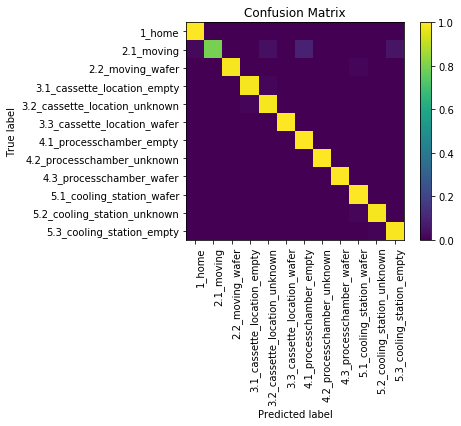

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# generate confusion matrix and normalize
confusion = confusion_matrix(confusion_labels, confusion_predictions)
confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

# discard labels that are not in the data
confusion_classes = unique_labels(confusion_labels, confusion_predictions)
confusion_classes = [label_name[i][1] for i in confusion_classes]

# setup plot
fig, ax = plt.subplots()
im = ax.imshow(confusion, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(confusion.shape[1]),
    yticks=np.arange(confusion.shape[0]),
    xticklabels=confusion_classes, yticklabels=confusion_classes,
    title="Confusion Matrix",
    ylabel='True label',
    xlabel='Predicted label'
)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

# save and show
plt.savefig("test.svg", format="svg", bbox_inches='tight')
plt.show()